## Aprendizaje de reglas de asociación

Objetivo:
    
    derivar reglas de la forma {A} -> {B}
    

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations, groupby
from collections import Counter
import sys
from IPython.display import display
from efficient_apriori import apriori
import json

In [2]:
#importar data
df_movies = pd.read_csv('ml-20m/movies.csv')
df_links = pd.read_csv('ml-20m/links.csv')
df_ratings = pd.read_csv('ml-20m/ratings.csv')
df_tags = pd.read_csv('ml-20m/tags.csv')


In [3]:
#print('movies -- dimensions: {0};   size: {1}'.format(df_movies.shape, size(df_movies)))
df_ratings.shape

(20000263, 4)

Lo primero que haremos sera concentrarnos en el dataset de peliculas. Podemos observar que las peliculas estan clasificadas por generos. Vamos a separar los generos en variables.

In [4]:
df_movies['splitgenres'] = df_movies['genres'].str.split('|',n=-1)
display(df_movies.head(10))
genres_list = df_movies['splitgenres']
display(genres_list)

,movieId,title,genres,splitgenres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]
5,6,Heat (1995),Action|Crime|Thriller,"[Action, Crime, Thriller]"
6,7,Sabrina (1995),Comedy|Romance,"[Comedy, Romance]"
7,8,Tom and Huck (1995),Adventure|Children,"[Adventure, Children]"
8,9,Sudden Death (1995),Action,[Action]
9,10,GoldenEye (1995),Action|Adventure|Thriller,"[Action, Adventure, Thriller]"


0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
5                                [Action, Crime, Thriller]
6                                        [Comedy, Romance]
7                                    [Adventure, Children]
8                                                 [Action]
9                            [Action, Adventure, Thriller]
10                                [Comedy, Drama, Romance]
11                                        [Comedy, Horror]
12                        [Adventure, Animation, Children]
13                                                 [Drama]
14                            [Action, Adventure, Romance]
15                                          [Crime, Drama]
16                                        [Drama, Romanc

In [5]:
#contamos cuantas veces aparece cada genero.
genre_count = genres_list.apply(pd.Series).stack().value_counts()
display(genre_count)
genre_count.plot.bar(figsize=(16, 4))

Drama                 13344
Comedy                 8374
Thriller               4178
Romance                4127
Action                 3520
Crime                  2939
Horror                 2611
Documentary            2471
Adventure              2329
Sci-Fi                 1743
Mystery                1514
Fantasy                1412
War                    1194
Children               1139
Musical                1036
Animation              1027
Western                 676
Film-Noir               330
(no genres listed)      246
IMAX                    196
dtype: int64

In [6]:
#Transformo las listas de generos en columnas con get dummies
# pd.get_dummies(df.categories.apply(pd.Series).stack()).sum(level=0)

gen_dummies = pd.get_dummies(df_movies['splitgenres'].apply(pd.Series).stack()).sum(level=0)
movies_wgenres = pd.concat([df_movies, gen_dummies], axis=1)
display(movies_wgenres.head())

,movieId,title,genres,splitgenres,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# dropeo las columnas que ya no uso y limpio el genero (no genres listed)
movies_wgenres = movies_wgenres.drop(columns=['genres','splitgenres','(no genres listed)'])
movies_wgenres.head(10)

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
6,7,Sabrina (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,8,Tom and Huck (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
movies_wgenres.shape

(27278, 21)

In [9]:
display(movies_wgenres.head())


,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### PLAYING WITH RATINGS

In [10]:
df_ratings.shape
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [11]:
##drop timestamp. Is useless
df_ratings = df_ratings.drop(columns=['timestamp'])

In [12]:
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

In [13]:
print('ratings -- dimensions: {0};   size: {1}'.format(df_ratings.shape, size(df_ratings)))

ratings -- dimensions: (20000263, 3);   size: 480.01 MB


#### So much data! "macrizamos" el dataset

In [14]:
df_ratings['rating'].unique()

array([3.5, 4. , 3. , 4.5, 5. , 2. , 1. , 2.5, 0.5, 1.5])

In [31]:
#ratings_sample = df_ratings.sample(n=round(len(df_ratings)*0.15))
ratings_sample = df_ratings

rating
0.5     239125
1.0     680732
1.5     279252
2.0    1430997
2.5     883398
3.0    4291193
3.5    2200156
4.0    5561926
4.5    1534824
5.0    2898660
dtype: int64

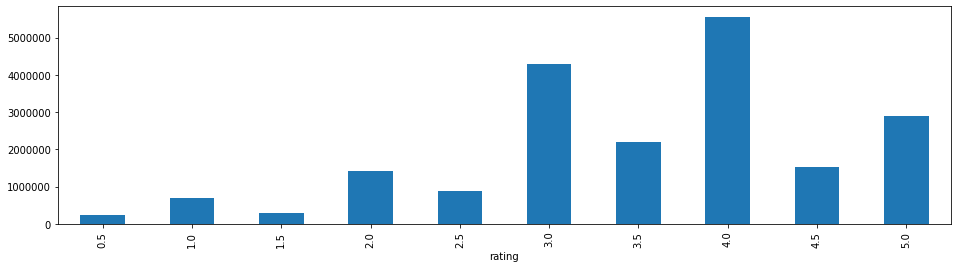

In [32]:
rating_count_s = ratings_sample.groupby('rating').size()
display(rating_count_s)
rating_count_s.plot.bar(figsize=(16, 4))

##### Siguen siendo muchos datos para transaccionar. Enfocaremos el algoritmo a los usuarios que han dado puntajes altos en este caso.

In [33]:
ratings_max = ratings_sample[ratings_sample['rating']>=5]
print('ratings_max -- dimensions: {0}; size: {1}'.format(ratings_max.shape, size(ratings_max)))

ratings_max -- dimensions: (2898660, 3); size: 92.76 MB


In [34]:
ratings_max.head(10)

,userId,movieId,rating
131,1,4993,5.0
142,1,5952,5.0
158,1,7153,5.0
170,1,8507,5.0
176,2,62,5.0
177,2,70,5.0
180,2,260,5.0
181,2,266,5.0
183,2,480,5.0
184,2,541,5.0


In [35]:
# ordeno por userId y movieId, luego agrupo las peliculas por usuario
# convierto en lista de transacciones
ratings_sorted = ratings_max.drop(columns='rating').sort_values(by=['userId','movieId'])
#ratings_group = ratings_sorted.groupby('userId')['movieId'].apply(list)
transactions = list(ratings_sorted.groupby('userId')['movieId'].apply(list))

for trans in transactions[:5]:
    print(trans)

[4993, 5952, 7153, 8507]
[62, 70, 260, 266, 480, 541, 589, 924, 1196, 1210, 1214, 1249, 1259, 1270, 1327, 1356, 1544, 1748, 1974, 2948, 3450, 3513, 3927, 3928, 3930, 3959]
[50, 175, 223, 260, 316, 318, 329, 457, 480, 490, 541, 593, 858, 904, 924, 953, 1060, 1073, 1084, 1089, 1097, 1129, 1196, 1197, 1198, 1206, 1208, 1210, 1213, 1214, 1220, 1221, 1222, 1230, 1240, 1242, 1247, 1257, 1258, 1259, 1261, 1266, 1270, 1276, 1278, 1304, 1321, 1356, 1374, 1375, 1676, 1831, 1909, 2009, 2046, 2076, 2093, 2117, 2118, 2150, 2288, 2391, 2448, 2529, 2571, 2628, 2710, 2788, 2791, 2872, 2918, 2968, 2985, 3033, 3039, 5060]
[454, 733]
[11, 62, 141, 150, 260, 318, 364, 368, 377, 380, 440, 454, 457, 500, 508, 531, 588, 589, 590, 594, 595, 671, 720, 736, 780, 832, 1028, 1035, 1036, 1079, 1080, 1097, 1136, 1196, 1198, 1210, 1291, 1393]


In [36]:
len(transactions)

131839

In [38]:
%%time
#itemsets, rules = apriori(transactions, min_support=0.002,  min_confidence=0.6, max_length=2)
#TRANSACTIONS GENERATOR
def data_generator():
    for t in transactions:
        yield t
        
min_support = 0.009
min_confidence = 0.4
max_length = 2
min_lift = 5

itemsets, rules = apriori(data_generator(), 
                          max_length=max_length,
                          min_support=min_support,
                          min_confidence=min_confidence)

KeyboardInterrupt: 

In [30]:
rules

[]

In [29]:
def get_movie_name(movie_id):
    title_object = movies_wgenres[movies_wgenres["movieId"] == movie_id]["title"]
    title = title_object.values[0]
    return title

In [ ]:
#ordenamos las rules por confidence
#recorro las rules y meto en lista para dumpear a un json 
rules_sort=sorted(rules, key=lambda rule: 1 - rule.confidence)
rules_list = list()
for rule in rules_sort:
    if rule.lift > min_lift:
        rules_json = {
            'left_id':rule.lhs[0],
            'left_Title':get_movie_name(rule.lhs[0])
            'right_id':rule.rhs[0],
            'right_Title':get_movie_name(rule.rhs[0])
            'conf': rule.confidence, 
            'supp': rule.support, 
            'lift': rule.lift,
            'conv': rule.conviction
        }
        rules_list.append(rules_json)

In [ ]:
# dump to json
rules_dump = json.dumps(rules_list, indent=2)
f = open('rules_json.json', 'w')
f.write(rules_dump)
f.close()

In [28]:
# output movies with rules
for rule in rules_list:
    output = ("If a person likes {} they will also like {} with confidence: {} , lift: {}".format(get_movie_title(rule.lhs[0]),
                                          get_movie_title(rule.rhs[0]),
                                          rule.confidence,
                                          rule.lift))
    print(output)